In [1]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram


IBMQ.save_account('ad3965ae3913db06521d71bba9e1208319b91a9e7ab869744cd624d63a8e898cfef58312e0819dcc2a1a2ffa59a867a4fdf5f6e225c6f2c80f28e03d3bb1a61a',overwrite=True)

#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)

#IBMQ.save_account('676f27667e5b533a92387a7716d67080d9648d217e96873f767e3834c2861bd4590a7ffbff31002cbce3f215642436c9a2e3a731e24b797ed5acd92765a463c2',overwrite=True)
#IBMQ.save_account('ebadbf7da56bb61d559a2f5fecd3d1d6e60d13ce5dd374f801829f3c92cd864b124e1ad5c1fd3faa6a14a5365f9d326947df8db138604049b06192da43d6a49b',overwrite=True)



IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends() 

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
from qiskit import *

In [3]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

In [4]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [5]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)


n=1
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
    
circuit = QuantumCircuit(qr, cr)
barriers = True


            # Apply Hadamard gate
circuit.h(qr)    
    

            # Apply Z-gate 
circuit.z(qr)  

            # Apply barrier 


            # Apply Hadamard gate
circuit.h(qr) 

            # Measure the register
    
for i in range(n):
    circuit.measure(qr[i], cr[i])

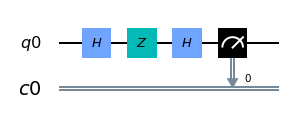

In [6]:
circuit.draw('mpl')

In [7]:
provider = IBMQ.get_provider(hub='ibm-q')
#device = provider.get_backend('ibmq_vigo')

In [8]:
FidelityFull1=[]
FidelityPartial1=[]
FidelityNoisy1=[]

JobIDFull1=[]
JobIDPartial1=[]
JobID_DJA1=[]

MatrixFull1=[]
MatrixPartial1=[]

In [9]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')
device = provider.get_backend('ibmq_ourense')
bit='1'

for j in range (0,14):
    
    Trials=2**j  
    #Trials=8192
    
    job = execute(circuit, backend=device, shots=Trials)
    device_result = job.result()
    a=device_result.get_counts(circuit).get(bit)
    
    
    cal_job = execute(cal_circuits,
             backend=device,
             shots=Trials,
             optimization_level=0)
    #print(cal_job.job_id())

    cal_results = cal_job.result()

    index=2**n-1
    cal_job_partial = execute(cal_circuits[index],
             backend=device,
             shots=Trials,
             optimization_level=0)
    cal_results_partial = cal_job_partial.result()
    #JobIDPartial.append(cal_job_partial.job_id())
   
    meas_fitter = CompleteMeasFitter(cal_results, state_labels)
    meas_fitter_partial = CompleteMeasFitter(cal_results_partial, state_labels)
    for k in range (2**n-1):
        meas_fitter_partial.cal_matrix[k,k]=1
        
    
    meas_filter_partial =meas_fitter_partial.filter
    mitigated_result_partial = meas_filter_partial.apply(device_result)
    mitigated_counts_partial = mitigated_result_partial.get_counts(circuit)
    
    meas_filter =meas_fitter.filter
    mitigated_result = meas_filter.apply(device_result)
    mitigated_counts = mitigated_result.get_counts(circuit)
    
    FidelityNoisy1.append(device_result.get_counts(circuit).get(bit)/Trials)
    FidelityPartial1.append(mitigated_counts_partial.get(bit)/Trials)
    FidelityFull1.append(mitigated_counts.get(bit)/Trials)
    
    JobIDFull1.append("'"+str(cal_job.job_id())+"'")
    JobIDPartial1.append("'"+str(cal_job_partial.job_id())+"'")
    JobID_DJA1.append("'"+str(job.job_id())+"'")
    
    MatrixFull1.append(meas_fitter.cal_matrix)
    MatrixPartial1.append(meas_fitter_partial.cal_matrix)

In [10]:
def MatlabStr(array):
    return '[' + "; ".join(" ".join("%6g" % val for val in line) for line in array) + ']'

In [11]:
print(FidelityFull1)
print(FidelityPartial1)
print(FidelityNoisy1)

print(JobIDFull1)
print(JobIDPartial1)
print(JobID_DJA1)

print(MatrixFull1)
print(MatrixPartial1)

[1.0, 1.0, 0.7499999999308178, 0.9999999999999977, 1.0, 0.966666666733154, 0.9682539664720468, 0.9759999990271857, 0.9999999999984521, 0.9817813765053195, 0.9969727547910845, 1.0, 0.9959047863238851, 0.9939109473969628]
[1.0, 1.0, 0.7500000003306133, 0.999999999999997, 1.0, 0.9999999999999866, 0.9999999999999614, 0.9919354842418803, 0.9999999999979363, 0.9801587301062645, 0.9989999999992394, 0.9994984954863618, 1.0, 0.9941080611552809]
[1.0, 1.0, 0.75, 1.0, 1.0, 0.9375, 0.96875, 0.9609375, 0.984375, 0.96484375, 0.9755859375, 0.97314453125, 0.96728515625, 0.968017578125]
["'5f2b406c0ca1ba0011b3d196'", "'5f2b420a0ca1ba0011b3d1aa'", "'5f2b43b4c79cc2001a3ac658'", "'5f2b4552fa2efe00139611d9'", "'5f2b473fc79cc2001a3ac676'", "'5f2b485c159e2600136cbbc6'", "'5f2b4a3d0ca1ba0011b3d1fa'", "'5f2b4bb2c79cc2001a3ac6ab'", "'5f2b4d6cfa2efe0013961227'", "'5f2b4ee20927b800133f96c5'", "'5f2b50c2c79cc2001a3ac6e0'", "'5f2b52764ae7da001b374163'", "'5f2b5301cbff540019b42cc3'", "'5f2b53960ca1ba0011b3d262'"]
["

# Full

In [14]:
for j in MatrixFull1:
    print(MatlabStr(j))

[     1      0;      0      1]
[     1      0;      0      1]
[     1      0;      0      1]
[     1      0;      0      1]
[     1      0;      0      1]
[0.96875 0.03125; 0.03125 0.96875]
[0.984375      0; 0.015625      1]
[0.992188 0.015625; 0.0078125 0.984375]
[0.988281 0.015625; 0.0117188 0.984375]
[0.982422 0.0175781; 0.0175781 0.982422]
[0.989258 0.0214844; 0.0107422 0.978516]
[0.990234 0.0297852; 0.00976562 0.970215]
[0.982666 0.0288086; 0.017334 0.971191]
[0.988403 0.026123; 0.0115967 0.973877]


# Partial

In [15]:
for j in MatrixPartial1:
    print(MatlabStr(j))

[     1      0;      0      1]
[     1      0;      0      1]
[     1      0;      0      1]
[     1      0;      0      1]
[     1 0.0625;      0 0.9375]
[     1 0.0625;      0 0.9375]
[     1 0.03125;      0 0.96875]
[     1 0.03125;      0 0.96875]
[     1 0.0273438;      0 0.972656]
[     1 0.015625;      0 0.984375]
[     1 0.0234375;      0 0.976562]
[     1 0.0263672;      0 0.973633]
[     1 0.0334473;      0 0.966553]
[     1 0.0262451;      0 0.973755]


In [1]:
A=[[[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[0.96875, 0.03125],
       [0.03125, 0.96875]], [[0.984375, 0.      ],
       [0.015625, 1.      ]], [[0.9921875, 0.015625 ],
       [0.0078125, 0.984375 ]], [[0.98828125, 0.015625  ],
       [0.01171875, 0.984375  ]], [[0.98242188, 0.01757812],
       [0.01757812, 0.98242188]], [[0.98925781, 0.02148438],
       [0.01074219, 0.97851562]], [[0.99023438, 0.02978516],
       [0.00976562, 0.97021484]], [[0.98266602, 0.02880859],
       [0.01733398, 0.97119141]], [[0.98840332, 0.02612305],
       [0.01159668, 0.97387695]]]

In [2]:
B=[[[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[1., 0.],
       [0., 1.]], [[1.    , 0.0625],
       [0.    , 0.9375]], [[1.    , 0.0625],
       [0.    , 0.9375]], [[1.     , 0.03125],
       [0.     , 0.96875]], [[1.     , 0.03125],
       [0.     , 0.96875]], [[1.        , 0.02734375],
       [0.        , 0.97265625]], [[1.      , 0.015625],
       [0.      , 0.984375]], [[1.       , 0.0234375],
       [0.       , 0.9765625]], [[1.        , 0.02636719],
       [0.        , 0.97363281]], [[1.        , 0.03344727],
       [0.        , 0.96655273]], [[1.        , 0.02624512],
       [0.        , 0.97375488]]]

In [7]:
def MatlabStr(array):
    return  "       ".join(" ".join("%f" % float(val) for val in line) for line in array)
w=0
    
for j in A:
    
    if w==0:
        print(" % N="+str(2**w)+" shot")
    else:
        print(" % N="+str(2**w)+" shots")
    print(MatlabStr(j))
    w=w+1

 % N=1 shot
1.000000 0.000000       0.000000 1.000000
 % N=2 shots
1.000000 0.000000       0.000000 1.000000
 % N=4 shots
1.000000 0.000000       0.000000 1.000000
 % N=8 shots
1.000000 0.000000       0.000000 1.000000
 % N=16 shots
1.000000 0.000000       0.000000 1.000000
 % N=32 shots
0.968750 0.031250       0.031250 0.968750
 % N=64 shots
0.984375 0.000000       0.015625 1.000000
 % N=128 shots
0.992188 0.015625       0.007812 0.984375
 % N=256 shots
0.988281 0.015625       0.011719 0.984375
 % N=512 shots
0.982422 0.017578       0.017578 0.982422
 % N=1024 shots
0.989258 0.021484       0.010742 0.978516
 % N=2048 shots
0.990234 0.029785       0.009766 0.970215
 % N=4096 shots
0.982666 0.028809       0.017334 0.971191
 % N=8192 shots
0.988403 0.026123       0.011597 0.973877


In [ ]:

1.000000 0.000000 % N=1 shot
0.000000 1.000000

1.000000 0.000000 % N=2 shots  
0.000000 1.000000

1.000000 0.000000 % N=4 shots    
0.000000 1.000000

1.000000 0.000000 % N=8 shots
0.000000 1.000000

1.000000 0.000000 % N=16 shots 
0.000000 1.000000

0.968750 0.031250 % N=32 shots
0.031250 0.968750

0.984375 0.000000 % N=64 shots
0.015625 1.000000

0.992188 0.015625 % N=128 shots
0.007812 0.984375

0.988281 0.015625 % N=256 shots 
0.011719 0.984375

0.982422 0.017578 % N=512 shots
0.017578 0.982422

0.989258 0.021484 % N=1024 shots
0.010742 0.978516

0.990234 0.029785 % N=2048 shots
0.009766 0.970215

0.982666 0.028809 % N=4096 shots 
0.017334 0.971191

0.988403 0.026123 % N=8192 shots
0.011597 0.973877

In [8]:
def MatlabStr(array):
    return  "       ".join(" ".join("%f" % float(val) for val in line) for line in array)
w=0
    
for j in B:
    
    if w==0:
        print(" % N="+str(2**w)+" shot")
    else:
        print(" % N="+str(2**w)+" shots")
    print(MatlabStr(j))
    w=w+1

 % N=1 shot
1.000000 0.000000       0.000000 1.000000
 % N=2 shots
1.000000 0.000000       0.000000 1.000000
 % N=4 shots
1.000000 0.000000       0.000000 1.000000
 % N=8 shots
1.000000 0.000000       0.000000 1.000000
 % N=16 shots
1.000000 0.062500       0.000000 0.937500
 % N=32 shots
1.000000 0.062500       0.000000 0.937500
 % N=64 shots
1.000000 0.031250       0.000000 0.968750
 % N=128 shots
1.000000 0.031250       0.000000 0.968750
 % N=256 shots
1.000000 0.027344       0.000000 0.972656
 % N=512 shots
1.000000 0.015625       0.000000 0.984375
 % N=1024 shots
1.000000 0.023438       0.000000 0.976562
 % N=2048 shots
1.000000 0.026367       0.000000 0.973633
 % N=4096 shots
1.000000 0.033447       0.000000 0.966553
 % N=8192 shots
1.000000 0.026245       0.000000 0.973755


In [ ]:
1.000000 0.000000 % N=1 shot
0.000000 1.000000

1.000000 0.000000 % N=2 shots
0.000000 1.000000

1.000000 0.000000 % N=4 shots
0.000000 1.000000

1.000000 0.000000 % N=8 shots
0.000000 1.000000

1.000000 0.062500 % N=16 shots
0.000000 0.937500

1.000000 0.062500 % N=32 shots
0.000000 0.937500

1.000000 0.031250 % N=64 shots
0.000000 0.968750

1.000000 0.031250 % N=128 shots
0.000000 0.968750

1.000000 0.027344 % N=256 shots
0.000000 0.972656

1.000000 0.015625 % N=512 shots
0.000000 0.984375

1.000000 0.023438 % N=1024 shots
0.000000 0.976562

1.000000 0.026367 % N=2048 shots
0.000000 0.973633

1.000000 0.033447 % N=4096 shots
0.000000 0.966553

1.000000 0.026245 % N=8192 shots
0.000000 0.973755

In [3]:
def stand7(w):
    if len(str(w))<9:
        return str(w)+(9-len(str(w)))*"0"  
    else:
        return str(w)[:9] 

def G7(ListMatr):
    logN=0
    for Matr in ListMatr:
        w=0
        for j in Matr:
            prnt=''
            for k in j:
                prnt=prnt+stand7(k)+" "
            if w==0:
                if logN==0:
                    prnt=prnt+"% N="+str(2**logN)+" shot"
                else:
                    prnt=prnt+"% N="+str(2**logN)+" shots"
            w=w+1
            print(prnt)
        logN=logN+1
        print('')

In [4]:
G7(A)

1.0000000 0.0000000 % N=1 shot
0.0000000 1.0000000 

1.0000000 0.0000000 % N=2 shots
0.0000000 1.0000000 

1.0000000 0.0000000 % N=4 shots
0.0000000 1.0000000 

1.0000000 0.0000000 % N=8 shots
0.0000000 1.0000000 

1.0000000 0.0000000 % N=16 shots
0.0000000 1.0000000 

0.9687500 0.0312500 % N=32 shots
0.0312500 0.9687500 

0.9843750 0.0000000 % N=64 shots
0.0156250 1.0000000 

0.9921875 0.0156250 % N=128 shots
0.0078125 0.9843750 

0.9882812 0.0156250 % N=256 shots
0.0117187 0.9843750 

0.9824218 0.0175781 % N=512 shots
0.0175781 0.9824218 

0.9892578 0.0214843 % N=1024 shots
0.0107421 0.9785156 

0.9902343 0.0297851 % N=2048 shots
0.0097656 0.9702148 

0.9826660 0.0288085 % N=4096 shots
0.0173339 0.9711914 

0.9884033 0.0261230 % N=8192 shots
0.0115966 0.9738769 



In [5]:
G7(B)

1.0000000 0.0000000 % N=1 shot
0.0000000 1.0000000 

1.0000000 0.0000000 % N=2 shots
0.0000000 1.0000000 

1.0000000 0.0000000 % N=4 shots
0.0000000 1.0000000 

1.0000000 0.0000000 % N=8 shots
0.0000000 1.0000000 

1.0000000 0.0625000 % N=16 shots
0.0000000 0.9375000 

1.0000000 0.0625000 % N=32 shots
0.0000000 0.9375000 

1.0000000 0.0312500 % N=64 shots
0.0000000 0.9687500 

1.0000000 0.0312500 % N=128 shots
0.0000000 0.9687500 

1.0000000 0.0273437 % N=256 shots
0.0000000 0.9726562 

1.0000000 0.0156250 % N=512 shots
0.0000000 0.9843750 

1.0000000 0.0234375 % N=1024 shots
0.0000000 0.9765625 

1.0000000 0.0263671 % N=2048 shots
0.0000000 0.9736328 

1.0000000 0.0334472 % N=4096 shots
0.0000000 0.9665527 

1.0000000 0.0262451 % N=8192 shots
0.0000000 0.9737548 

